## 基于Keras的简单文本分类——豆瓣影评分类

## data source
+ 用爬虫获得豆瓣电影评论 https://github.com/aakaking/get_douban_comment

## data processing
+ clean data
+ Select the same amount of data from each category(数据均衡)
+ comment to id
+ pad comment

## model

+ Embedding
+ CNN
+ Bi-LSTM
+ Dropout
+ Fully connected    

## reference

+ https://github.com/vivanraaj/Sentiment-Analysis-on-Movie-Reviews/blob/master/CNNLSTM_model.ipynb 
+ https://blog.csdn.net/weiwei9363/article/details/78876896


### 1、data processing

+ loading data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('douban_movie_comments.csv',encoding='gb18030')

In [3]:
data['comment'] = data['comment'].fillna('')

In [4]:
data.head()

,id,name,year,comment,star
0,1304485,穿越时空爱上你 Kate & Leopold,2001,在这个速食、什么都讲究快捷的年代，我们不可能被如此温柔绅士地对待，生活也不会随便扔给我们一个...,4
1,1304485,穿越时空爱上你 Kate & Leopold,2001,特么滥套的大俗片啊，特么不严谨的剧情啊，可是俺一点也不讨厌它呀，谁让演员长得好也演的好啊！,4
2,1304485,穿越时空爱上你 Kate & Leopold,2001,...太浪漫了...简直是每个女人都想拥有的男人 =vvvvvvv=,5
3,1304485,穿越时空爱上你 Kate & Leopold,2001,啊，布莱因小姐\r\n 您的舞姿就象……就象一群牲口\r\n 您是个少有的女人\...,3
4,1304485,穿越时空爱上你 Kate & Leopold,2001,我的软肋 就是爱情轻喜剧.....,5


In [5]:
from collections import Counter

In [6]:
Counter(data['star'])

Counter({1: 10822, 2: 7134, 3: 14966, 4: 22692, 5: 16146})

In [7]:
import numpy as np

In [8]:
sample = 5000
random_indices = np.random.choice(np.arange(len(data['comment'])), sample)

In [9]:
sub_data = data.iloc[random_indices]

In [10]:
Counter(sub_data['star'])

Counter({1: 752, 2: 526, 3: 1043, 4: 1566, 5: 1113})

+ Clearn data

In [11]:
from opencc import OpenCC
import jieba

def is_CN_char(ch):
    return ch >= u'\u4e00' and ch <= u'\u9fa5'

def cut(string):
    return list(jieba.cut(string))

def get_stopwords(filename = "D:/Code/Pycharm/Data_source/chinese_stopwords.txt"):
    stopwords_dic = open(filename, encoding= 'utf-8')
    stopwords = stopwords_dic.readlines()
    stopwords = [w.strip() for w in stopwords]
    stopwords_dic.close()
    return stopwords

def convert2simple(word):
    openCC = OpenCC('tw2sp')
    return openCC.convert(word)

In [12]:
stopwords = get_stopwords()

In [14]:
stopwords[:50]

['，',
 '的',
 '。',
 '、',
 '在',
 '了',
 '是',
 '',
 '“',
 '”',
 '和',
 '年',
 '月',
 '：',
 '也',
 '）',
 '为',
 '（',
 '有',
 '%',
 '日',
 '将',
 '中',
 '-',
 '到',
 '与',
 '对',
 ':',
 '',
 '上',
 '都',
 '等',
 '不',
 '他',
 '》',
 '《',
 '就',
 '但',
 '我',
 '而',
 '这',
 '会',
 '并',
 '；',
 '被',
 '后',
 '人',
 '从',
 '还',
 '1']

In [15]:
def clean_sentence(sentence):
    stopwords = get_stopwords()
    sentence = ''.join(filter(is_CN_char,sentence))
    sentence = convert2simple(sentence)
    words = [w for w in cut(sentence) if len(w)>1 and w not in stopwords]
    words = ' '.join(words)
    return words  

In [16]:
sub_data['comment'] = sub_data['comment'].apply(clean_sentence)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Anan\AppData\Local\Temp\jieba.cache
Loading model cost 0.803 seconds.
Prefix dict has been built succesfully.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
sub_data.head()

,id,name,year,comment,star
47130,3592859,囚徒 Prisoners,2013,星半 结尾 拖沓 男主角 最后 举动 有失 逻辑 牵强 刻意 摄影 教科书 级别,4
66767,26035290,悟空传,2017,预期 一些 特效 不错 剧情 可圈可点 彭于 口音 稍微 出戏 不过 整体 还好 郑爽 出场...,4
39018,1309046,V字仇杀队 V for Vendetta,2005,好看 感动 味道,5
54978,1292287,新龙门客栈 新龍門客棧,1992,阅遍 红尘 金镶玉,5
36014,1292233,发条橙 A Clockwork Orange,1971,整个 装逼 啥意思,2


In [18]:
sub_data['comment'][:10]

47130             星半 结尾 拖沓 男主角 最后 举动 有失 逻辑 牵强 刻意 摄影 教科书 级别
66767    预期 一些 特效 不错 剧情 可圈可点 彭于 口音 稍微 出戏 不过 整体 还好 郑爽 出场...
39018                                             好看 感动 味道
54978                                            阅遍 红尘 金镶玉
36014                                            整个 装逼 啥意思
8037     形式 内容 并重 经典 巧妙 多线 叙事 人物 相互 穿插 叠层 牵扯 枪击 事件 发生 俯...
13894    喜欢 也许 这片 俗套 滥情 碎片 分钟 喜欢 人大 可一耸 肩膀 不是 所有人 青春 有点...
5356     巧合 今天 恰好 谍影 重重 上映 周年 原名 大卫 韦伯 杰森 波恩 比上 一部 更加 孤...
15362    没有 真正 特工 哈里 眼睛 哈里 利用 间谍 侦查 手段 令到 西蒙 洋相百出 化妆 法国...
70579                                   我手 真贱 以后 再下 大陆 恐怖片
Name: comment, dtype: object

+ id-to-word & word-to-id

In [19]:
def word_to_id(vocab):
    counts = Counter(vocab)
    vocab = sorted(counts, key=counts.get, reverse=True)
    word_to_id = { word : i for i, word in enumerate(vocab)}
    id_to_word = {i:word for i,word in enumerate(vocab)}
    return word_to_id, id_to_word

In [20]:
vocab = ' '.join(sub_data['comment']).split()
vocab.append('unknown')
word_to_id, id_to_word = word_to_id(vocab)

In [21]:
len(vocab)

75837

In [22]:
vocab[:10]

['星半', '结尾', '拖沓', '男主角', '最后', '举动', '有失', '逻辑', '牵强', '刻意']

In [23]:
word_to_id

{'电影': 0,
 '一个': 1,
 '故事': 2,
 '没有': 3,
 '喜欢': 4,
 '最后': 5,
 '导演': 6,
 '一部': 7,
 '什幺': 8,
 '片子': 9,
 '不是': 10,
 '真的': 11,
 '剧情': 12,
 '觉得': 13,
 '这部': 14,
 '感觉': 15,
 '但是': 16,
 '这种': 17,
 '看到': 18,
 '真是': 19,
 '不错': 20,
 '好看': 21,
 '其实': 22,
 '不过': 23,
 '生活': 24,
 '知道': 25,
 '有点': 26,
 '影片': 27,
 '演技': 28,
 '结尾': 29,
 '镜头': 30,
 '演员': 31,
 '爱情': 32,
 '非常': 33,
 '世界': 34,
 '完全': 35,
 '实在': 36,
 '角色': 37,
 '人物': 38,
 '表演': 39,
 '很多': 40,
 '节奏': 41,
 '现在': 42,
 '细节': 43,
 '已经': 44,
 '不能': 45,
 '结局': 46,
 '一直': 47,
 '青春': 48,
 '情节': 49,
 '经典': 50,
 '两个': 51,
 '出来': 52,
 '可能': 53,
 '比较': 54,
 '剧本': 55,
 '一种': 56,
 '配乐': 57,
 '男人': 58,
 '现实': 59,
 '时间': 60,
 '画面': 61,
 '孩子': 62,
 '之后': 63,
 '美国': 64,
 '可爱': 65,
 '那种': 66,
 '一起': 67,
 '一点': 68,
 '作品': 69,
 '中国': 70,
 '以为': 71,
 '应该': 72,
 '特别': 73,
 '观众': 74,
 '风格': 75,
 '所有': 76,
 '女人': 77,
 '一次': 78,
 '这是': 79,
 '烂片': 80,
 '问题': 81,
 '社会': 82,
 '不会': 83,
 '人生': 84,
 '本片': 85,
 '简直': 86,
 '里面': 87,
 '时代': 88,
 '看过': 89,
 '除了': 90,
 '东西': 91

In [24]:
id_to_word

{0: '电影',
 1: '一个',
 2: '故事',
 3: '没有',
 4: '喜欢',
 5: '最后',
 6: '导演',
 7: '一部',
 8: '什幺',
 9: '片子',
 10: '不是',
 11: '真的',
 12: '剧情',
 13: '觉得',
 14: '这部',
 15: '感觉',
 16: '但是',
 17: '这种',
 18: '看到',
 19: '真是',
 20: '不错',
 21: '好看',
 22: '其实',
 23: '不过',
 24: '生活',
 25: '知道',
 26: '有点',
 27: '影片',
 28: '演技',
 29: '结尾',
 30: '镜头',
 31: '演员',
 32: '爱情',
 33: '非常',
 34: '世界',
 35: '完全',
 36: '实在',
 37: '角色',
 38: '人物',
 39: '表演',
 40: '很多',
 41: '节奏',
 42: '现在',
 43: '细节',
 44: '已经',
 45: '不能',
 46: '结局',
 47: '一直',
 48: '青春',
 49: '情节',
 50: '经典',
 51: '两个',
 52: '出来',
 53: '可能',
 54: '比较',
 55: '剧本',
 56: '一种',
 57: '配乐',
 58: '男人',
 59: '现实',
 60: '时间',
 61: '画面',
 62: '孩子',
 63: '之后',
 64: '美国',
 65: '可爱',
 66: '那种',
 67: '一起',
 68: '一点',
 69: '作品',
 70: '中国',
 71: '以为',
 72: '应该',
 73: '特别',
 74: '观众',
 75: '风格',
 76: '所有',
 77: '女人',
 78: '一次',
 79: '这是',
 80: '烂片',
 81: '问题',
 82: '社会',
 83: '不会',
 84: '人生',
 85: '本片',
 86: '简直',
 87: '里面',
 88: '时代',
 89: '看过',
 90: '除了',
 91: '东西'

+ comment to id

In [25]:
def comment_to_id(word_to_id,comments):
    comment_to_id = []
    for comment in comments:
        comment_to_id.append([word_to_id[word] for word in comment.split()] )
    return comment_to_id

In [26]:
comment_to_id = comment_to_id(word_to_id,sub_data['comment'])

In [27]:
comment_to_id[:10]

[[2811, 29, 632, 355, 5, 4959, 8263, 260, 1909, 231, 107, 3589, 3590],
 [1181,
  127,
  169,
  20,
  12,
  1077,
  1443,
  2812,
  1302,
  725,
  23,
  177,
  527,
  4960,
  767,
  16,
  138,
  1910,
  2282,
  502,
  28,
  527],
 [21, 128, 275],
 [8264, 4961, 8265],
 [132, 1911, 8266],
 [475,
  528,
  4962,
  50,
  675,
  893,
  92,
  38,
  971,
  894,
  4963,
  4964,
  4965,
  375,
  376,
  2283,
  3591,
  3592,
  431,
  476,
  4966,
  3593,
  4967,
  4968,
  4969,
  377,
  4970,
  377,
  42,
  4971,
  2813,
  4972,
  4973],
 [4,
  139,
  149,
  555,
  2814,
  2284,
  110,
  4,
  8267,
  8268,
  8269,
  10,
  633,
  48,
  26,
  2814,
  26,
  555,
  14,
  0,
  211,
  477,
  768,
  2815,
  2285,
  4974,
  8270,
  3594,
  3595,
  8271,
  3596,
  2286,
  356],
 [1078,
  232,
  1912,
  3597,
  1444,
  556,
  4975,
  8272,
  3598,
  8273,
  4976,
  8274,
  4977,
  7,
  307,
  4978,
  4979,
  307,
  1913,
  66,
  1914,
  4980,
  2287,
  8275,
  94,
  2816,
  34,
  3599,
  30,
  895,
  393,
 

+ padding

In [28]:
def pad_sequences(comment_to_id,maxlen,padding='post',truncating='post'):
    features = np.zeros((len(comment_to_id), maxlen), dtype=int)
    for i,comment in enumerate(comment_to_id):
        if len(comment) <= maxlen and padding == 'pre':
            features[i, -len(comment):] = np.array(comment)[:maxlen]
        if len(comment) <= maxlen and padding == 'post':
            features[i, :len(comment)] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'post':
            features[i, :] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'pre':
            features[i, :] = np.array(comment)[len(comment)-maxlen:]           
    return features

In [29]:
pad_comments = pad_sequences(comment_to_id,maxlen=200,padding='post',truncating='post')

In [30]:
pad_comments[:10]

array([[2811,   29,  632, ...,    0,    0,    0],
       [1181,  127,  169, ...,    0,    0,    0],
       [  21,  128,  275, ...,    0,    0,    0],
       ...,
       [1078,  232, 1912, ...,    0,    0,    0],
       [   3,  119, 1304, ...,    0,    0,    0],
       [8285, 8286,  336, ...,    0,    0,    0]])

In [31]:
pad_comments.shape

(5000, 200)

+ split data

In [32]:
import random

In [33]:
def split_dataset(pad_comments,labels,split_frac):
    split_index = int(len(pad_comments)*split_frac)
    data_list = list(zip(pad_comments, labels))
    random.shuffle(data_list)
    pad_comments, labels = zip(*data_list)
    x_train, x_test = pad_comments[:split_index], pad_comments[split_index:]
    y_train, y_test = labels[:split_index], labels[split_index:]
    return x_train,y_train,x_test,y_test 

In [34]:
num_labels = 5

In [35]:
labels = (np.arange(num_labels) == np.array(sub_data['star'])[:,None]).astype(np.float32)

In [36]:
labels[:10]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [37]:
x_train,y_train,x_test,y_test = split_dataset(pad_comments,labels,0.8)

## Model

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.merge import add
from keras.layers import LSTM,Bidirectional, Dropout,GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import regularizers

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [39]:
max_comment_length = 200
embedding_vecor_length = 300

In [41]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test) 

+ 使用keras的history观察loss以及accuracy的变化

In [42]:
model = Sequential()
model.add(Embedding(len(word_to_id), embedding_vecor_length, input_length=max_comment_length, dropout=0.2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax', activity_regularizer=regularizers.l2(0.001)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,validation_split=0.20, epochs=5,verbose=1, batch_size=300)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          6092400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          33200     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20)                8880      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
Total para

+ 使用matplotlib画出loss变化的趋势；

In [43]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


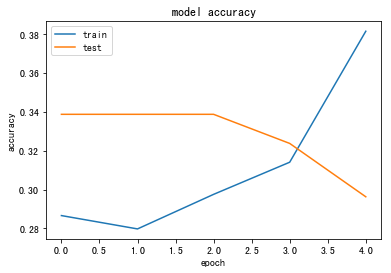

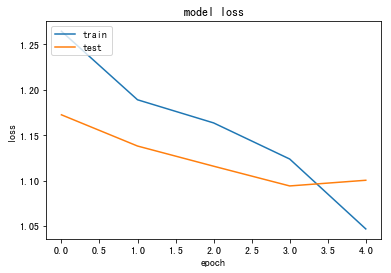

29.3


In [44]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

preds = model.predict(x_test)
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
print(accuracy(preds,y_test))

## 优化

1. 分析存在的问题 
2. 思考优化方法
3. 对比预期结果和实际结果
4. 分析原因

## Result

+ 豆瓣1星2星评论作为差评，5星评论作为好评，验证集和测试集准确度为80%（约3w条评论）
+ 豆瓣1星2星评论作为差评，5星评论作为好评，3星评论作为中评，验证集和测试集准确度为60%（约4w5条评论）
+ 按星数做5分类，验证集和测试集准确度为40%（约3w条数据）

## Summary

+ benchmark——从每个类别中选取相同数量的数据。
+ pretrained embedding——在该项目中并未提高准确率，使用wikipedia corpus训练的的word2vec时，有很多词没有出现，准确率下降，使用影评corpus训练的word2vec，可能因为句子不够丰富，并没有体现出word2vec的优势，准确度没有提高，所以最后选择了embedding layer。
+ 关于模型单层双向LSTM结果优于多层单向LSTM。
+ 观察训练集和测试集loss发现过拟合，可以使用早停法，减小epoch，或者增加数据量。
+ 关于结果精度，数据方面，清洗过后有些评论只剩一个词，这部分并未去除，另外打分很主观，相邻分数差别模糊；模型方面还可以调整参数，增加Attention机制。

### 在有预先训练的词向量时候，keras如何实现embeding操作

回答：create a weight matrix for words in training docs and do notupdate the learned word weights in this model.
   ```python:
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in t.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
     keras:
     e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)

    ```
+ 个人经验是，在有预训练的词向量的情况下再通过网络微调效果略好，即trainable设置为Ture

## 文本分类经验分享——Kaggle : Toxic Comment Classification Challenge   

+ https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
+ https://www.kaggle.com/yekenot/pooled-gru-fasttext

本项目对来自Wikipedia’s talk页面的评论数据集建立一个多标签识别模型，识别恶意评论的类别，比如威胁，侮辱，身份歧视等，使得用户可以选择某类感兴趣的评论。
+  首先选用简单的Pooled GRU + FastText模型得到的AUC Score有0.9816，效果不错，但是再通过修改模型就很难提升AUC。
+  text normalization：修复错拼单词（out-of-vocabulary），创建一个词表包含恶意评论中的高频词，对每个错拼单词查询这个列表，选择编辑距离小的词来纠正这个错拼单词。利用TextBlob dictionary修复错拼单词。利用Fasttext tool创建错拼单词的词向量。
+  data augmentation：通过把文本翻译成外文再翻译回来的方式增加数据，减小过拟合。需要注意的是信息泄露的可能性，要保证原始评论和翻译评论在同一边，也就是同一句的语料要被分在相同的数据集。
+  model ensemble：在不同的预训练的embedding上独立训练多个模型进行平均（FastText and Glove embedding）。
+  模型框架是 Embedding + Dropout + Bi-GRU + Pooling(average pooling + max Pooling) + Fully connected。
+  最终将ACU Score 提高到0.9862，全球排名Top 20%。

## 问题回复

### Q1： 今年要参加校招，发现牛客网上面很多人写的面经里面问的问题课上都没有讲过，想问一下，这应该怎么复习啊？

+ 1.面经是要看的，相当于是划重点，时间紧的话可以看面经整理一些问题。
+ 2.有时间的话推荐阅读经典教材+前沿论文。
+ 3.吃透项目，熟悉项目中的技术细节，包括存在的问题及改进的方向。
+ 4.还需要注意的是算法基础和编程能力，刷题对于面试是很有必要的，强大的编程能力会让你脱颖而出。
+ 5.利用已有知识解决具体问题的能力。
+ reference https://github.com/imhuay/Algorithm_Interview_Notes-Chinese

### Q2: topological _sort算法讲解
+ reference https://www.geeksforgeeks.org/topological-sorting/

In [ ]:
#Python program to print topological sorting of a DAG 
from collections import defaultdict 
  
#Class to represent a graph 
class Graph: 
    def __init__(self,vertices): 
        self.graph = defaultdict(list) #dictionary containing adjacency List 
        self.V = vertices #No. of vertices 
  
    # function to add an edge to graph 
    def addEdge(self,u,v): 
        self.graph[u].append(v) 
  
    # A recursive function used by topologicalSort 
    def topologicalSortUtil(self,v,visited,stack): 
  
        # Mark the current node as visited. 
        visited[v] = True
  
        # Recur for all the vertices adjacent to this vertex 
        for i in self.graph[v]: 
            if visited[i] == False: 
                self.topologicalSortUtil(i,visited,stack) 
  
        # Push current vertex to stack which stores result 
        stack.insert(0,v) 
  
    # The function to do Topological Sort. It uses recursive  
    # topologicalSortUtil() 
    def topologicalSort(self): 
        # Mark all the vertices as not visited 
        visited = [False]*self.V 
        stack =[] 
  
        # Call the recursive helper function to store Topological 
        # Sort starting from all vertices one by one 
        for i in range(self.V): 
            if visited[i] == False: 
                self.topologicalSortUtil(i,visited,stack) 
  
        # Print contents of the stack 
        print(stack)
  
g= Graph(6) 
g.addEdge(5, 2); 
g.addEdge(5, 0); 
g.addEdge(4, 0); 
g.addEdge(4, 1); 
g.addEdge(2, 3); 
g.addEdge(3, 1); 
  
print("Following is a Topological Sort of the given graph")
g.topologicalSort() 
#This code is contributed by Neelam Yadav 

### Q3: mini-flow中运用到的Python技巧，比如参数传递，继承什么的；


mini-flow中用到的概念主要是Object-Oriented Programming (OOP)面向对象编程，这里有一个很好的资料可以参考https://realpython.com/python3-object-oriented-programming/

### Q4: 第二个大项目一级指标分类和评论情感分类的思路(是简单粗暴的文本分类么，还是说有其他技巧)，像kaggle toxic comment classification f1 score可以达到94%，这个项目的模型怎么评价呢

kaggle toxic comment classification这个项目是按照AUC score来评价的。AUC的解释https://blog.csdn.net/liweibin1994/article/details/79462554

### Q5: 希望可以用代码，展示一下某一个当下流行的模型（比如BERT）处理某一个问题的过程。（预训练模型和fine-tuning的区别感觉也不怎么明白，希望可以在代码演示过程中也讲一下）

BERT了解不多，这里有一些资料一起学习。    
原始论文翻译：https://mp.weixin.qq.com/s/HhW7PcFhrVWjWt1qNx-anQ    
TensorFlow源码分析：https://1024er.github.io/bert-squad-tf/    
BERT阅读理解：https://mp.weixin.qq.com/s/C5B4QO0fxWtBwA5iv3XzcA    
扩展阅读：https://mp.weixin.qq.com/s/Wf-Qbj0b2ZIVBr_cr11LFg 、 https://mp.weixin.qq.com/s/b-HYzrSa4MF2zHYdxbtKcg 、
https://bigquant.com/community/t/topic/156035?utm_source=weibo&utm_medium=weibo_bq&utm_campaign=190619_L1




### Q6: 希望可以讲解一下transformer和openAI GPT原理。（GPT感觉没看懂……）

这个应该还没讲到这里，课上会讲，可以先看一些资料了解一下。
+ https://blog.csdn.net/pipisorry/article/details/84946653
+ https://blog.csdn.net/pipisorry/article/details/84951508

### Q7: 上次的新华社抄袭的那个感觉演示的不完整，文本相似度和edit distance 没有讲  老师这次可否接着上次的往下再讲一下呢？

https://github.com/aakaking/Text-plagiarism-judgment